<a href="https://phelma-sicom.gricad-pages.univ-grenoble-alpes.fr/1a/3pmpols6-cours" target="_blank">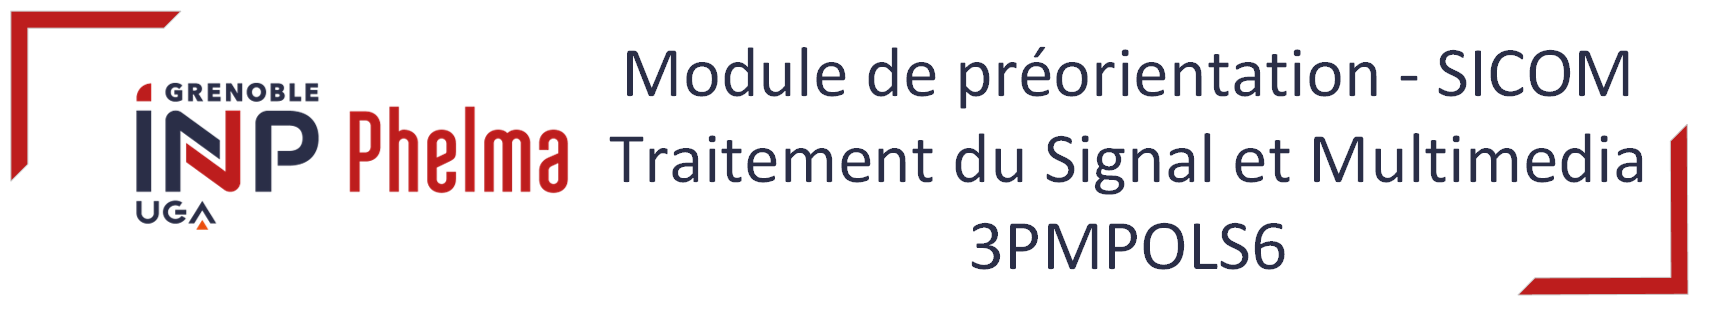</a>

# TD 2 - Partie 2

**Objectifs de ce TD :**

- 🖼️ Comprendre les **réseaux de neurones de convolution (CNN)**
- 🧠 Comprendre les différences de fonctionnement entre les réseaux de neurones **denses** et de **convolution**
___

## Préparation : mise en place de l'environnement de travail du TD

Cette **phase préparatoire** se déroule en deux temps :

1. **Importation des bibliothèques** Python nécessaires pour le TD

💻 *Exécuter le code de la cellule et vérifier qu'il n'y a pas d'erreurs. Un message de warning doit apparaître. A quoi correspond ce message ?*

In [1]:
## Importation des bibliothèques Python nécessaires au TD
import urllib.request

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist


from PIL import Image

import matplotlib.pyplot as plt
import random

import ipywidgets as widgets

from IPython.display import display
from IPython.display import Markdown as md

import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2. **Création des fonctions** pour générer les **images utilisées** pour le TD

💻 *Exécuter le code de la cellule*

In [2]:
def create_seven_segment_display(number=0, sigma=1, norm=True):
    image = np.zeros((28, 28)) # Image noir de fond
    # Position des segments sur l'image
    segments = {
        'a': [(max(0, round(random.gauss(2, sigma))), i) for i in range(7, 21)],
        'b': [(i, min(27, round(random.gauss(22, sigma)))) for i in range(3, 13)],
        'c': [(i, min(27, round(random.gauss(22, sigma)))) for i in range(15, 25)],
        'd': [(min(27, round(random.gauss(25, sigma))), i) for i in range(7, 21)],
        'e': [(i, max(0, round(random.gauss(5, sigma)))) for i in range(15, 25)],
        'f': [(i, max(0, round(random.gauss(5, sigma)))) for i in range(3, 13)],
        'g': [(max(0, min(27, round(random.gauss(13, sigma)))), i) for i in range(7, 21)],
    }
    # Liste des positions des segments pour les valeurs héxadécimales
    digits = [
        "abcdef", "bc", "abged", "abgcd", "fgbc",
        "afgcd", "afgcde", "fabc", "abcdefg", "abcdfg",
        "efabcg", "fedcg", "afed", "bcdeg", "afged",
        "afge",
    ]
    # Création du chiffre choisi dans le paramètre "number"
    for seg in [segments[dig] for dig in digits[number]]:
        for y, x in seg:
            if norm is True:
                image[y, x] = 1
            else:
                image[y, x] = 255
    return image




def create_dataset(nb_train=6000, nb_test=1000, val=(3, 15), sigma=1, all_nb=False, norm=True):
    X_train, y_train, X_test, y_test = [], [], [], []
    # Toutes les valeurs hexadicémales (suppression des deux valeurs par défaut)
    if all_nb is True:
        val = range(0, 10)
    for _ in range(nb_train):
        for digit in val:
            X_train.append(create_seven_segment_display(digit, sigma, norm=norm))
            if all_nb is True:
                y_train.append(digit)
            else:
                y_train.append(0 if digit==val[0] else 1)
    for _ in range(nb_test):
        for digit in val:
            X_test.append(create_seven_segment_display(digit, sigma, norm=norm))
            if all_nb is True:
                y_test.append(digit)
            else:
                y_test.append(0 if digit==val[0] else 1)
    return (np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))




def create_new_dataset(dataset, rand=True, zero=True):
    """
    Fonction pour générer des nouvelles données
    à partir du jeu de données MNIST, Fashion MNIST
    """
    if rand is None or zero is None:
        raise ValueError("Les paramètres rand et zero doivent être définis")
    new_size = (56, 56)
    positions = ["haut_gauche", "haut_droite", "bas_gauche", "bas_droite"]
    new_dataset = list()
    for image in dataset:
        if zero is True:
            new_image = np.zeros((56, 56))
        else:
            new_image = np.random.rand(56, 56)
        if rand is True:
            pos_x = random.randint(0, 56-28)
            pos_y = random.randint(0, 56-28)
            new_image[pos_x:pos_x+28, pos_y:pos_y+28] = image.reshape(28, 28)
        else:
            pos = random.choice(positions)
            if pos=="haut_gauche":
                new_image[0:28, 0:28] = image.reshape(28, 28)
            elif pos=="haut_droite":
                new_image[0:28, 28:] = image.reshape(28, 28)
            elif pos=="bas_gauche":
                new_image[28:, 0:28] = image.reshape(28, 28)
            elif pos=="bas_droite":
                new_image[28:, 28:] = image.reshape(28, 28)
        new_dataset.append(new_image.reshape(56, 56, 1))
    new_dataset = np.array(new_dataset)
    return new_dataset

3. **Création des fonctions** pour générer les **modèles de réseaux de neurones** pour le TD

💻 *Exécuter le code de la cellule*

In [3]:
def fcn(input_shape=(28, 28, 1), output=1, activation="sigmoid"):
    """
    Création du réseau de neurones complétement connecté
    """
    print("Réseau dense")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(name="Couche_entree"),
            layers.Dense(output, activation=activation, name="Couche_sortie"),
        ]
    )
    print(model.summary())
    return model




def cnn(input_shape=(56, 56, 1), output=1, activation="sigmoid"):
    """
    Création du réseau de neurones de convolution
    """
    print("Réseau CNN")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(1, kernel_size=(28, 28), activation="relu", strides=(28, 28)),
            layers.Flatten(),
            layers.Dense(output, activation=activation, name="Couche_sortie"),
        ]
    )
    #checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', save_weights_only=True, period=1)
    print(model.summary())
    return model




def train_evaluate(model, x_train, y_train, x_test, y_test, loss="binary_crossentropy", epochs=10):
    """
    Entrainement et évaluation du modèle
    """
    model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    return score[1]


def evaluate(model, x_test, y_test):
    """
    Evaluation du modèle
    """
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test accuracy:", score[1]*100, "%")
    return score[1]

___

## Manipulation 1 : génération des images des bases d'apprentissage et de test

💻 *Exécuter le code et analyser les dimensions de l'image. A quoi correspondent les 3 dimensions de l'image ?*

In [4]:
num_classes = 10
(x_train, y_train, x_test, y_test) = create_dataset(sigma=0.3, all_nb=True, norm=True)
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape[0], "Images d'entrainement")
print(x_test.shape[0], "Images de test")
print("Dimensions d'une image : ", x_train[0].shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 Images d'entrainement
10000 Images de test
Dimensions d'une image :  (28, 28, 1)


💻 *Exécuter le code et analyser l'image. L'étiquette est-elle cohérente avec l'image ?*

Etiquette :  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


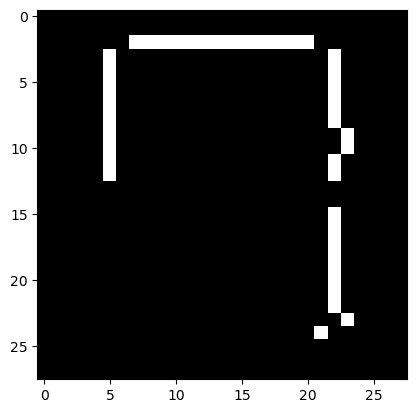

In [5]:
rnd_value = random.randint(0, 60000)
print("Etiquette : ", y_train[rnd_value])
plt.imshow(x_train[rnd_value], cmap='gray')
plt.show()

💻 *Exécuter le code et analyser l'image. Essayer différents combinaisons de paramètres `rand` et `zero`*


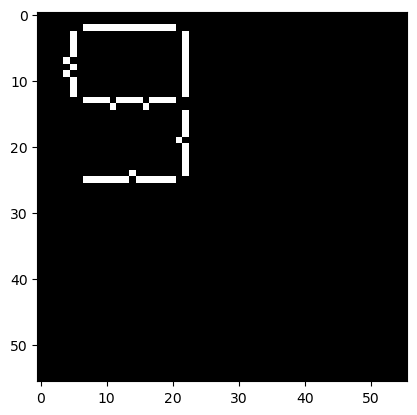

In [6]:
rnd_value = random.randint(0, 600)
new_x_train = create_new_dataset(x_train, rand=False, zero=True)
new_x_test = create_new_dataset(x_test, rand=False, zero=True)
plt.imshow(new_x_train[rnd_value], cmap='gray')
plt.show()

___

## Manipulation 2 : réseau complètement connecté
### Définition et apprentissage du réseau

💻 *Exécuter le code et analyser le résultat de l'entrainement du réseau dense.*

In [7]:
model_fcn = fcn(input_shape=(56, 56, 1), output=10, activation="softmax")
result_fcn = train_evaluate(model_fcn, 
                            new_x_train, y_train, 
                            new_x_test, y_test, 
                            loss="categorical_crossentropy", 
                            epochs=10)

Réseau dense
Metal device set to: Apple M2 Pro


2024-02-15 11:36:27.981593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-15 11:36:27.981711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Couche_entree (Flatten)     (None, 3136)              0         
                                                                 
 Couche_sortie (Dense)       (None, 10)                31370     
                                                                 
Total params: 31,370
Trainable params: 31,370
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2024-02-15 11:36:28.851737: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-15 11:36:28.984061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


419/422 [============================>.] - ETA: 0s - loss: 2.2858 - accuracy: 0.5406

2024-02-15 11:36:33.918320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 5s 9ms/step - loss: 2.2857 - accuracy: 0.5431 - val_loss: 2.2685 - val_accuracy: 0.8717
Epoch 2/10
422/422 [==============================] - 3s 8ms/step - loss: 2.2517 - accuracy: 0.8960 - val_loss: 2.2348 - val_accuracy: 0.9963
Epoch 3/10
422/422 [==============================] - 4s 9ms/step - loss: 2.2181 - accuracy: 0.9551 - val_loss: 2.2015 - val_accuracy: 0.9998
Epoch 4/10
422/422 [==============================] - 4s 9ms/step - loss: 2.1849 - accuracy: 0.9748 - val_loss: 2.1686 - val_accuracy: 0.9998
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 2.1522 - accuracy: 0.9969 - val_loss: 2.1362 - val_accuracy: 0.9995
Epoch 6/10
422/422 [==============================] - 3s 8ms/step - loss: 2.1199 - accuracy: 0.9770 - val_loss: 2.1042 - val_accuracy: 0.9997
Epoch 7/10
422/422 [==============================] - 3s 8ms/step - loss: 2.0881 - accuracy: 0.9946 - val_loss: 2.0726 - val_accuracy: 0.9998
Epoch 8/10
422/42

### Analyse des performances et des poids du modèle

💻 *Exécuter le code pour analyser les performances du modèle*

126/313 [===========>..................] - ETA: 0s

2024-02-15 11:37:07.208098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step
Test accuracy: 99.75000023841858 %


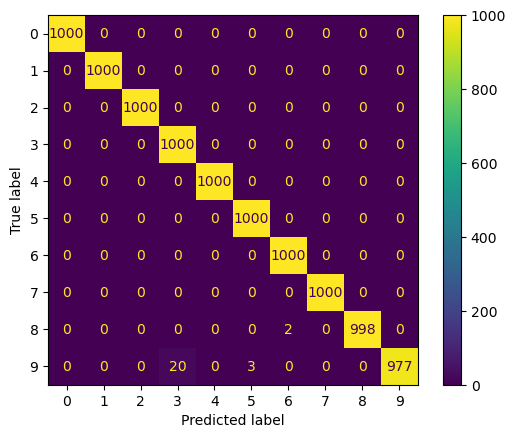

In [8]:
y_pred = model_fcn.predict(new_x_test)

predicted_categories = np.argmax(y_pred, axis=1)
true_categories      = np.argmax(y_test, axis=1)

cm_fcn = confusion_matrix(true_categories, predicted_categories, 
                          labels=np.arange(0,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fcn,
                              display_labels=np.arange(0,10))


evaluate(model_fcn, new_x_test, y_test)
disp.plot()

💻 *Exécuter le code et analyser les poids du modèle*

In [9]:
# Extraire les poids de la première couche dense
weights_fcn = model_fcn.layers[1].get_weights()[0]
weights_reshaped_fcn = weights_fcn.reshape(56, 56, -1)

# Fonction pour mettre à jour le graphique
def update_plot(neuron_index):

    print(f"Exemples de données d'entrainement pour le chiffre {neuron_index}")
    # Afficher 10 images
    fig, axs = plt.subplots(1, 10, figsize=(15, 15))
    count = 0
    for i in range(1000):
        if y_train[i].argmax()==neuron_index:
            axs[count].imshow(new_x_train[i], cmap='gray')
            axs[count].axis('off')
            count += 1
        if count==10:
            break
    plt.show()
    

    print(f'Représentation statique des poids du neurone {neuron_index} de la couche de sortie')
    im=plt.imshow(weights_reshaped_fcn[:, :, neuron_index], cmap='gray')
    plt.colorbar(im, orientation='vertical')
    plt.axis('off')
    plt.show()

# Création de la liste déroulante
neuron_selector = widgets.IntSlider(
    value=0,
    min=0,
    max=9,
    step=1,
    description='Neurone:',
    continuous_update=False
)

# Interactivité
widgets.interactive(update_plot, neuron_index=neuron_selector)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Neurone:', max=9), Output()), _…

___

## Manipulation 3 : réseau convolutif

Pour **faciliter la compréhension** des poids des filtres de convolution, le réseau de neurones est entrainé pour **détecter un chiffre** parmi les 10 (de 0 à 9).

💻 *Exécuter le code pour créer le nouveau jeu de données. Analyser les nouveaux jeux de données créés.*

In [10]:
indexToDetect = 6 # chiffre que l'on veut détecter parmi les 10 chiffres

# Création du nouveau jeu de données
def create_indices(x, y, indexToDetect):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    final_indice = []
    for i in indices:
        if y[i].argmax()==indexToDetect:
            final_indice.append(i)
        else:
            if random.random()>0.9:
                final_indice.append(i)
    return final_indice


train_indices = create_indices(new_x_train, y_train, indexToDetect)
test_indices = create_indices(new_x_test, y_test, indexToDetect)


# Mise à jour des données
x_train_binary = new_x_train[train_indices]
y_train_binary = (y_train[train_indices].argmax(axis=1)==indexToDetect).astype(int)
x_test_binary = new_x_test[test_indices]
y_test_binary = (y_test[test_indices].argmax(axis=1)==indexToDetect).astype(int)

### Définition et apprentissage du réseau
💻 *Exécuter le code et analyser le résultat de l'entrainement du réseau de convolution.*

In [17]:
model_cnn = cnn(input_shape=(56, 56, 1))

try:
  model_cnn.load_weights("weights.11-0.67.hdf5")
except FileNotFoundError:
  urllib.request.urlretrieve("https://gricad-gitlab.univ-grenoble-alpes.fr/bayartpi/phelma-sicom-3pmpols6-td/-/raw/main/content/weights.11-0.67.hdf5", "weights.11-0.67.hdf5")


acc_cnn = train_evaluate(model_cnn, 
                         x_train_binary, y_train_binary, 
                         x_test_binary, y_test_binary, 
                         loss="binary_crossentropy", epochs=60)

Réseau CNN
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 2, 2, 1)           785       
                                                                 
 flatten_2 (Flatten)         (None, 4)                 0         
                                                                 
 Couche_sortie (Dense)       (None, 1)                 5         
                                                                 
Total params: 790
Trainable params: 790
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
 1/80 [..............................] - ETA: 22s - loss: 0.6710 - accuracy: 0.5938

2024-02-15 11:39:21.197858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x1xi1>'
l

80/80 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.5488

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x112x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x112x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformance

80/80 [==============================] - 1s 11ms/step - loss: 0.6667 - accuracy: 0.5488 - val_loss: 0.6642 - val_accuracy: 0.4639
Epoch 2/60
25/80 [========>.....................] - ETA: 0s - loss: 0.6634 - accuracy: 0.5531

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x112x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x112x1x1xi1>'


80/80 [==============================] - 1s 7ms/step - loss: 0.6631 - accuracy: 0.5559 - val_loss: 0.6602 - val_accuracy: 0.5731
Epoch 3/60
80/80 [==============================] - 1s 7ms/step - loss: 0.6594 - accuracy: 0.5896 - val_loss: 0.6559 - val_accuracy: 0.6197
Epoch 4/60
80/80 [==============================] - 1s 7ms/step - loss: 0.6551 - accuracy: 0.6055 - val_loss: 0.6516 - val_accuracy: 0.6162
Epoch 5/60
80/80 [==============================] - 1s 7ms/step - loss: 0.6505 - accuracy: 0.6183 - val_loss: 0.6468 - val_accuracy: 0.6303
Epoch 6/60
80/80 [==============================] - 1s 7ms/step - loss: 0.6456 - accuracy: 0.6215 - val_loss: 0.6418 - val_accuracy: 0.6338
Epoch 7/60
80/80 [==============================] - 1s 8ms/step - loss: 0.6405 - accuracy: 0.6295 - val_loss: 0.6364 - val_accuracy: 0.6391
Epoch 8/60
80/80 [==============================] - 1s 7ms/step - loss: 0.6350 - accuracy: 0.7026 - val_loss: 0.6307 - val_accuracy: 0.7051
Epoch 9/60
80/80 [=============

80/80 [==============================] - 1s 8ms/step - loss: 0.2749 - accuracy: 0.9148 - val_loss: 0.2687 - val_accuracy: 0.9164


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


Test loss: 0.2744504511356354
Test accuracy: 0.9076763391494751


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'


### Analyse des performances et des poids du réseau
💻 *Exécuter le code pour analyser les performances du modèle*

61/61 [==============================] - 0s 2ms/step


2024-02-15 11:40:07.805760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 90.76763391494751 %


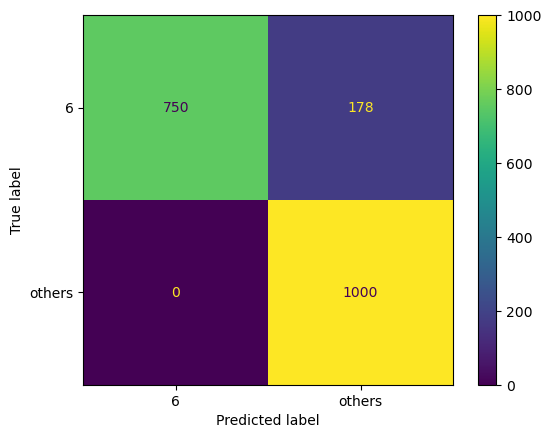

In [18]:
y_pred_cnn_binary = model_cnn.predict(x_test_binary)

predicted_categories_cnn_binary = y_pred_cnn_binary>.5
true_categories_cnn_binary      = y_test_binary

cm_fcn_cnn_binary = confusion_matrix(true_categories_cnn_binary, predicted_categories_cnn_binary)
disp_cnn_binary = ConfusionMatrixDisplay(confusion_matrix=cm_fcn_cnn_binary,
                              display_labels=(indexToDetect, 'others'))


evaluate(model_cnn, x_test_binary, y_test_binary)
disp_cnn_binary.plot()

💻 *Exécuter le code et analyser les poids du modèle*

Représentation statique des poids du noyau de convolution


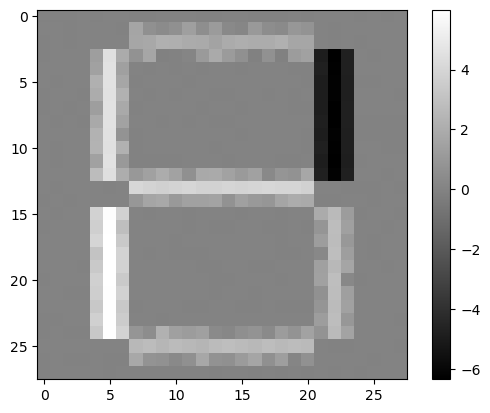

In [19]:
weights = model_cnn.layers[0].get_weights()[0]
weights_reshaped = weights.reshape(28, 28, -1)    


print('Représentation statique des poids du noyau de convolution')
im=plt.imshow(weights_reshaped, cmap="gray")
plt.colorbar(im, orientation='vertical')
plt.show()

<a href="https://phelma.grenoble-inp.fr" target="_blank">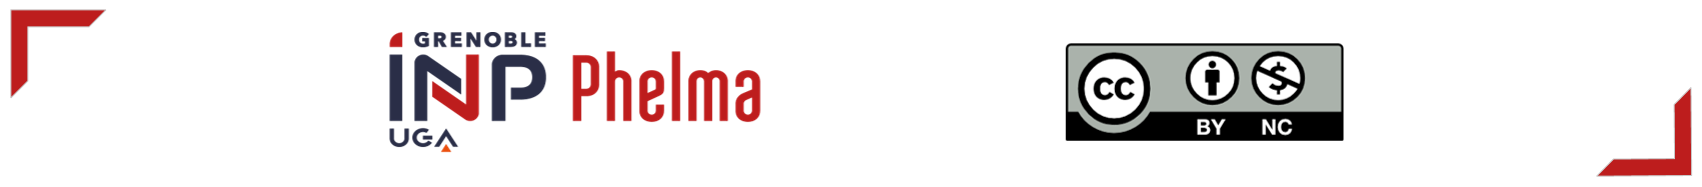</a>